# Observational Fairness on COMPAS Dataset
### Julia L. Wang

Reproducing: 

*   Dressel, Julia, and Hany Farid (2018). “The accuracy, fairness, and limits of predicting recidivism."

*   Wadsworth, Christina, Francesca Vera, and Chris Piech (2018). “Achieving fairness through adversarial learning: an application to recidivism prediction.”

Using the COMPAS dataset. 

In [37]:
# Initialization
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import functional as F

# COMPAS dataset
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,14001422CF10A,2014-01-31,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-02-01,Risk of Violence,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:01,2014-01-14 07:49:46,14000581CF10A,2014-01-13,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-01-14,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,0,2,0,0,3,-1.0,2014-03-08 08:06:02,2014-03-09 12:18:04,140033

## Some Definitions

**Calibration:** positive predictive value (PPV) parity and negative predictive value (NPV) parity since the risk scores are 0/1 for not recidivate/ recidivate


*   PPV parity: P ( actually recidivate | model predicts recidivate) is equal for each demographic
*   NPV parity: P( actually recidivate | model predicts won't recidivate) is equal for each demographic



**False-positive parity:** P( model outputs recidivate | didn't actually recidivate) is equal regardless of demographic. 

##  Part 1: Logistic Regression Model

Reproducing Dressel et al. (2019) to predict 2-year recidivism. Dressel et al. split the data into 80% training and 20% testing, where they trained different models with 2  and 7 features respectively. This section will replicate their training using 2 features, and test for false-positive parity and calibration between Caucasian and African-American demographics. 

In [51]:
## Splitting the data into training and test sets
train, test = train_test_split(df, test_size=0.2) #20% test size

## Training data we need- 2 features: age, priors_count
train_data = torch.tensor(train[["age", "priors_count"]].to_numpy().astype(np.float32))
train_targets = torch.tensor(train[["two_year_recid"]].to_numpy().astype(np.float32))

## Test data for testing all demographics
test_data = torch.tensor(test[["age", "priors_count"]].to_numpy().astype(np.float32))
test_targets = torch.tensor(test[["two_year_recid"]].to_numpy().astype(np.float32))

## Getting test data by race for comparison
caucasian = df[(df.race == "Caucasian")]
aa = df[(df.race == "African-American")]

# get caucasian and african-american data in the training set
aa_in_training = train.merge(aa, on=["id"])
caucasian_in_training = train.merge(caucasian, on=["id"])

# test sets: caucasian and aa not in the training set
aa_test = aa[~aa.id.isin(aa_in_training.id)]
caucasian_test = caucasian[~caucasian.id.isin(caucasian_in_training.id)]

## final data and targets for each demographic
cc_data = torch.tensor(caucasian_test[["age", "priors_count"]].to_numpy().astype(np.float32))
cc_targets = torch.tensor(caucasian_test[["two_year_recid"]].to_numpy().astype(np.float32))

aa_data = torch.tensor(aa_test[["age", "priors_count"]].to_numpy().astype(np.float32))
aa_targets = torch.tensor(aa_test[["two_year_recid"]].to_numpy().astype(np.float32))

# inputs into training logistic regression
x_train = train_data
y_train = train_targets

In [53]:
## Creating logistic regression model

class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

model = LogisticRegression(2, 1)

In [54]:
## Training the model

# set model parameters
criterion = torch.nn.BCELoss() # binary cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Adam optimizer

# Training the model
for epoch in range(1000):
    y_pred = model(x_train) # get model output by inputting the training data
    loss = criterion(y_pred, y_train) # computing loss
    loss.backward()                   # Backward pass

    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1)%100 == 0: # print the accuracy and loss for every 100 epochs
      model_out = torch.where(y_pred>0.50, 1, 0)
      truth = torch.sum(torch.eq(model_out, y_train).int())
      print("Model accuracy is ", truth/y_pred.shape[0], ". Loss is: ", loss.item())


Model accuracy is  tensor(0.6663) . Loss is:  0.7008139491081238
Model accuracy is  tensor(0.6668) . Loss is:  0.6173121333122253
Model accuracy is  tensor(0.6664) . Loss is:  0.6167641282081604
Model accuracy is  tensor(0.6746) . Loss is:  0.6164642572402954
Model accuracy is  tensor(0.6748) . Loss is:  0.6162203550338745
Model accuracy is  tensor(0.6758) . Loss is:  0.6160369515419006
Model accuracy is  tensor(0.6751) . Loss is:  0.6159080266952515
Model accuracy is  tensor(0.6751) . Loss is:  0.615822970867157
Model accuracy is  tensor(0.6761) . Loss is:  0.6157701015472412
Model accuracy is  tensor(0.6789) . Loss is:  0.6157390475273132


In [59]:
## Running the model on the test sets

caucasian_pred = model(cc_data) # caucasian test set
aa_pred = model(aa_data)        # african-american test set
overall_pred = model(test_data) # overall case with all demographics


### Calibration and False-Positive parity

In [67]:
def FalsePosRate(model_out, y_test):
  """
    model_out: models predictions of positive or negative (1/0)
    y_test: the ground truth values
    output: the false positive rate = # false positives / total true negatives
  """
  false_pos_count = 0
  total_neg_count = 0

  for i in range(len(model_out)):
    if y_test[i] == 0: # true  negative case
      total_neg_count+=1
      if model_out[i] != y_test[i]: #false pos when true negative & model predicts positive
        false_pos_count+=1
  # print("\tAmount of false positives:", false_pos_count)
  # print("\tAmount of negatives:", total_neg_count)

  return false_pos_count/total_neg_count

# print(FalsePosRate(model_out, y_test))

In [74]:
def Calibration(model_out, targets):
  """
    model_out: the models prediction of 0/1
    targets: the ground truth values
    outputs: PPV = P(ground truth = reoffend | model predicts reoffend)
            NPV = 1 - P(ground truth = reoffend | model predicts won't reoffend)
  """
  total_pos_count = 0
  total_neg_count = 0
  ppv_count = 0
  npv_count = 0

  for i in range(len(model_out)):
    if model_out[i] == 0: # model negative (reoffend)
      total_neg_count+=1
      if targets[i] ==1:  # true positive
        npv_count += 1
        
    else: # model positive case(reoffend)
      total_pos_count += 1
      if targets[i] == 1: # true positive
        ppv_count += 1
  
  PPV = ppv_count/total_pos_count
  NPV = 1-(npv_count/total_neg_count)

  return PPV, NPV

In [78]:
## Showing that the model fails to satisfy false-positive parity

# Assigning model predictions to 0 or 1
caucasian_pred_thresholded = torch.where(caucasian_pred > 0.5, 1, 0)
aa_pred_thresholded = torch.where(aa_pred > 0.5, 1, 0)

# Calculating false positive rate for each demographic
caucasian_fpr = FalsePosRate(caucasian_pred_thresholded, cc_targets)
print("Caucasian false positive rate:", caucasian_fpr)

aa_fpr = FalsePosRate(aa_pred_thresholded, aa_targets)
print("African-American false positive rate:", aa_fpr)

## conclusion:
print("Difference between them is:", aa_fpr - caucasian_fpr)

#since the false positive rates were not the same between the 2, 
#there is no false positive parity

Caucasian false positive rate: 0.15593220338983052
African-American false positive rate: 0.27548209366391185
Difference between them is: 0.11954989027408133


In [79]:
## Showing that the model satisfies calibration

cc_ppv, cc_npv = Calibration(caucasian_pred_thresholded, cc_targets)
aa_ppv, aa_npv = Calibration(aa_pred_thresholded, aa_targets)

print("Caucasian PPV: ", cc_ppv, " African-American PPV: ", aa_ppv, "Difference = ", aa_ppv-cc_ppv)
print("Caucasian NPV: ", cc_npv, " African-American NPV: ", aa_npv, "Difference = ", aa_npv-cc_npv)


Caucasian PPV:  0.6567164179104478  African-American PPV:  0.6978851963746223 Difference =  0.04116877846417455
Caucasian NPV:  0.6821917808219178  African-American NPV:  0.6477832512315271 Difference =  -0.034408529590390646


### Comparing the differences in the demographics for false-positive parity and calibration

For the purposes of this lab, I will define a difference to be significant if it 10% or greater. Thus, it can be seen above that the model does not satisfy false-positive parity since the difference between the false positive rates (FPRs) is 11.95%. On the other hand, the differences between the PPVs and NPVs are 4.12% and 3.44% respectively, which is significantly lower than the difference in FPR. Since having both PPV parity and NPV parity means that we have calibration, the model satisfies calibration.

Relation with difference in base rates in the dataset

Text(0.5, 1.0, 'Effect of threshold on FPR')

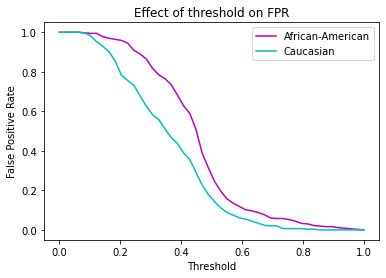

In [69]:
## Show adjusting thresholds satisfies false-positive parity 
thresholds = np.linspace(0, 1) # change threshold from 0 to 1 on the x-axis

# generate FPR rates for cc and aa
cc_fpr = []
aa_fpr = []

for i in thresholds:
  # taking each model output with different thresholds
  cc_thresholded = torch.where(caucasian_pred>i, 1, 0)
  aa_thresholded = torch.where(aa_pred>i, 1, 0)
  cc_fpr.append(FalsePosRate(cc_thresholded, cc_targets))
  aa_fpr.append(FalsePosRate(aa_thresholded, aa_targets))

# conversion to np array for plotting
cc_fpr = np.array(cc_fpr)
aa_fpr = np.array(aa_fpr)

# plotting
plt.plot(thresholds, aa_fpr, label = "African-American", color = "m")
plt.plot(thresholds, cc_fpr, label = "Caucasian", color= "c")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("False Positive Rate")
plt.title("Effect of threshold on FPR")


Plotting false positive rates with respect to different threshold values leads to the figure above. As such, it can be seen that a threshold of around 0.1 or 0.9 leads to false-positive parity where the rates match between demographics. Selecting these thresholds, let's try to check the calibration.

In [80]:
## Show that thresholds satisfying false-positive parity doesn't satisfy calibration
caucasian_pred_thresholded = torch.where(caucasian_pred > 0.1, 1, 0)
aa_pred_thresholded = torch.where(aa_pred > 0.1, 1, 0)

cc_ppv, cc_npv = Calibration(caucasian_pred_thresholded, cc_targets)
aa_ppv, aa_npv = Calibration(aa_pred_thresholded, aa_targets)

print("For 0.1 Threshold:")
print("Caucasian PPV: ", cc_ppv, " African-American PPV: ", aa_ppv, "Difference = ", aa_ppv-cc_ppv)
print("Caucasian NPV: ", cc_npv, " African-American NPV: ", aa_npv, "Difference = ", aa_npv-cc_npv)

For 0.1 Threshold:
Caucasian PPV:  0.4117647058823529  African-American PPV:  0.5081743869209809 Difference =  0.09640968103862801
Caucasian NPV:  0.8333333333333334  African-American NPV:  0.6666666666666667 Difference =  -0.16666666666666663


For the thresholds for which my model satisfied false-positive parity, the differences in PPV and NPV were significant (>10%), therefore, calibration is not satisfied after the threshold adjustment. 

Further statistical testing is required to conclude the significance of the differences between demographics for false-positive rates, PPV, and NPV. 

## Part 2: Adversial Learning Procedure

Reproducing Wadsworth et al. (2018) to produce more accurate classifier satisfying false-postiive partiy by introducing more features and using adversial learning technique

### Results
Features used: 

Comparison to Wadsworth:

False-positive disparity